In [3]:
import numpy as np
from netCDF4 import Dataset, num2date # to work with NetCDF files
from os.path import expanduser
import matplotlib.pyplot as plt
home = expanduser("~") # Get users home directory
import statsmodels.api as sm
from scipy import stats
plt.rcParams.update({'font.size': 30})

import xarray as xr
import pytz
import glob, os
import numpy as np
import matplotlib.pyplot as plt     
import matplotlib.dates as mdates
import datetime
from dateutil import tz
import metpy.calc as mpcalc
from metpy.units import units

import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.patches import Circle
import matplotlib.colors as colors
import matplotlib.cm as cmx


In [4]:
dir_profile = "/run/media/ludo/DATA/google-drive/Thèse/EUREC4a/github/EUREC4A_rad_profiles/output"

path_to_dropsonde_profiles = os.path.join(dir_profile,"dropsondes","rad_profiles_all_dropsondes.nc")
path_to_radiosonde_profiles = os.path.join(dir_profile, "radiosondes", "rad_profiles_all_radiosondes.nc")

# Load profiles

In [5]:
dropsonde_profiles = xr.open_dataset(path_to_dropsonde_profiles)
print(dropsonde_profiles)

<xarray.Dataset>
Dimensions:      (launch_time: 1162, zlay: 1000, zlev: 1001)
Coordinates:
    lay          int32 ...
    col          int32 ...
  * zlay         (zlay) int64 5 15 25 35 45 55 ... 9945 9955 9965 9975 9985 9995
  * zlev         (zlev) int64 0 10 20 30 40 50 ... 9960 9970 9980 9990 10000
  * launch_time  (launch_time) datetime64[ns] 2020-01-19T16:14:09 ... 2020-02-11T09:48:23
    play         (launch_time, zlay) float64 ...
    plev         (launch_time, zlev) float64 ...
Data variables:
    platform     (launch_time) object ...
    tlay         (launch_time, zlay) float64 ...
    h2o          (launch_time, zlay) float64 ...
    sfc_emis     (launch_time) float64 ...
    sfc_alb      (launch_time) float64 ...
    sfc_t        (launch_time) float64 ...
    cos_sza      (launch_time) float64 ...
    lw_dn        (launch_time, zlev) float64 ...
    lw_up        (launch_time, zlev) float64 ...
    lw_net       (launch_time, zlev) float64 ...
    sw_dn        (launch_time, zle

In [6]:
radiosonde_profiles = xr.open_dataset(path_to_radiosonde_profiles)
print(radiosonde_profiles)

<xarray.Dataset>
Dimensions:      (launch_time: 1453, zlay: 1000, zlev: 1001)
Coordinates:
    col          int32 ...
    lay          int32 ...
  * zlev         (zlev) int64 0 10 20 30 40 50 ... 9960 9970 9980 9990 10000
  * zlay         (zlay) int64 5 15 25 35 45 55 ... 9945 9955 9965 9975 9985 9995
  * launch_time  (launch_time) datetime64[ns] 2020-01-16T15:14:58 ... 2020-02-16T04:14:33
    play         (launch_time, zlay) float64 ...
    plev         (launch_time, zlev) float64 ...
Data variables:
    platform     (launch_time) uint8 ...
    tlay         (launch_time, zlay) float64 ...
    h2o          (launch_time, zlay) float64 ...
    sfc_emis     (launch_time) float64 ...
    sfc_alb      (launch_time) float64 ...
    sfc_t        (launch_time) float64 ...
    cos_sza      (launch_time) float64 ...
    lw_dn        (launch_time, zlev) float64 ...
    lw_up        (launch_time, zlev) float64 ...
    lw_net       (launch_time, zlev) float64 ...
    sw_dn        (launch_time, zlev

In [7]:
all_profiles = xr.concat([dropsonde_profiles, radiosonde_profiles], dim="launch_time")

In [8]:
print(all_profiles)

<xarray.Dataset>
Dimensions:      (launch_time: 2615, zlay: 1000, zlev: 1001)
Coordinates:
    col          int32 1
    lay          int32 1
  * zlay         (zlay) int64 5 15 25 35 45 55 ... 9945 9955 9965 9975 9985 9995
  * zlev         (zlev) int64 0 10 20 30 40 50 ... 9960 9970 9980 9990 10000
  * launch_time  (launch_time) datetime64[ns] 2020-01-19T16:14:09 ... 2020-02-16T04:14:33
    play         (launch_time, zlay) float64 1.014e+05 1.013e+05 ... 2.768e+04
    plev         (launch_time, zlev) float64 1.014e+05 1.013e+05 ... 2.766e+04
Data variables:
    platform     (launch_time) object 'HALO' 'HALO' 'HALO' 'HALO' ... 5 5 5 5
    tlay         (launch_time, zlay) float64 298.2 298.1 298.0 ... 238.7 238.7
    h2o          (launch_time, zlay) float64 0.02445 0.02453 ... 3.904e-05
    sfc_emis     (launch_time) float64 0.98 0.98 0.98 0.98 ... 0.98 0.98 0.98
    sfc_alb      (launch_time) float64 0.07 0.07 0.07 0.07 ... 0.07 0.07 0.07
    sfc_t        (launch_time) float64 300.4 300.

# Large scale characteristics

In [9]:
def get_relative_humidity(profiles):
    
    profiles["play"].attrs['units'] = 'hPa'
    profiles["tlay"].attrs['units'] = 'kelvin'
    
    rh = mpcalc.relative_humidity_from_mixing_ratio(profiles["mr"], profiles["tlay"], profiles["play"])
    
    profiles["rh"] = (["launch_time","zlay"], rh.magnitude)  #volume to mass mixing ratio
    
    
    return profiles

In [40]:
def plot_mr_and_tlay(profiles):
    plt.rcParams.update({'font.size': 25})
    
    profiles = get_relative_humidity(profiles)
    
    mr_mean = profiles["mr"].mean(dim="launch_time")*1000
    mr_std = (profiles["mr"]*1000).std(dim="launch_time")
    
    tlay_mean = profiles["tlay"].mean(dim="launch_time")
    tlay_std = profiles["tlay"].std(dim="launch_time")
    
    zlay = profiles["zlay"]/1000
    
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    
    ax[0].set_xlabel('Mixing ratio (g/kg)')
    ax[0].set_ylabel('Altitude (km)')  
    ax[1].set_xlabel('Temperature (K)')

    ax[0].set_xlim([0,18]) 

    ymin=0
    ymax=10
    for k in range(2):
        ax[k].grid(color='k', linestyle='--', linewidth=0.8)
        ax[k].set_ylim([ymin,ymax]) 
        ax[k].tick_params(direction='in', bottom=True, top=True, left=True, right=True,grid_alpha=1)
        for axis in ['top','bottom','left','right']:
              ax[k].spines[axis].set_linewidth(1.3)
        
    cl= "k"
    alpha=0.20
    
    ax[0].fill_betweenx(zlay,mr_mean - mr_std, mr_mean + mr_std, 
                alpha=alpha, color=cl)    
    ax[0].plot(mr_mean, zlay, color=cl)
    
    ax[1].fill_betweenx(zlay,tlay_mean - tlay_std, tlay_mean + tlay_std, 
                alpha=alpha, color=cl)    
    ax[1].plot(tlay_mean, zlay, color=cl)
    
    ax[1].tick_params(labelleft=False)  
    
   # fig.tight_layout() 
    
  #  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
       
    fig.savefig('../Figures/tlay_and_mr_profiles.jpg')

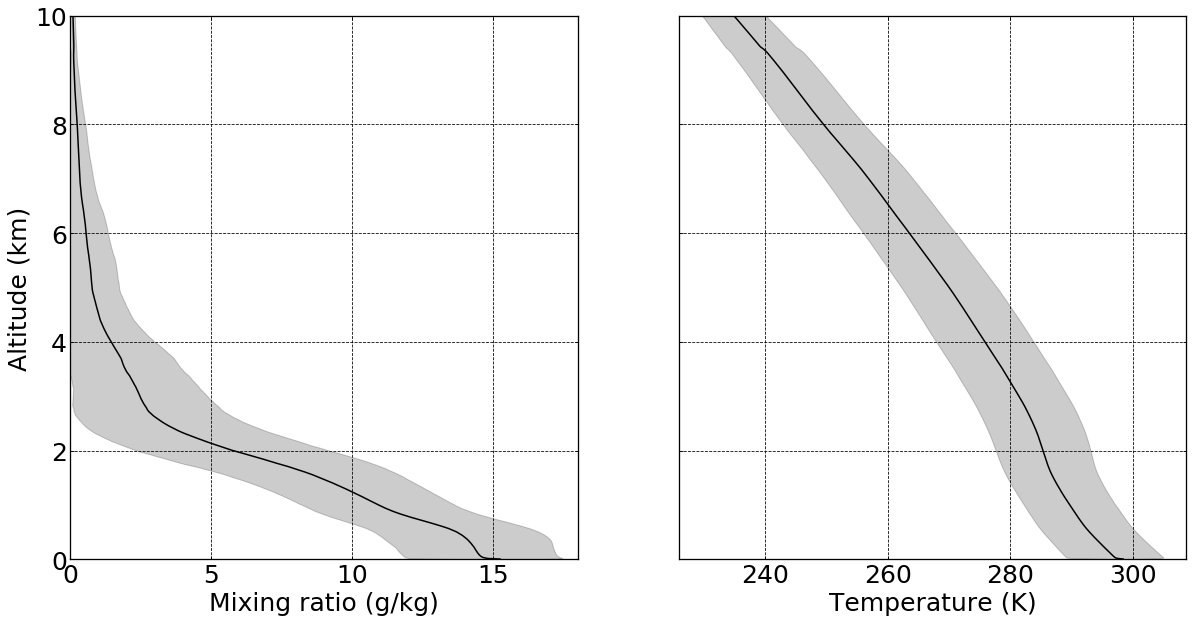

In [41]:
plot_mr_and_tlay(all_profiles)

# Average Radiative Profiles

In [42]:
def plot_rad_profiles(profiles):

    
    plt.rcParams.update({'font.size': 25})
    
    q_rad_mean = profiles["q_rad"].mean(dim="launch_time")
    q_rad_std = profiles["q_rad"].std(dim="launch_time")
    
    q_rad_lw_mean = profiles["q_rad_lw"].mean(dim="launch_time")
    q_rad_lw_std = profiles["q_rad_lw"].std(dim="launch_time")
    
    q_rad_sw_mean = profiles["q_rad_sw"].mean(dim="launch_time")
    q_rad_sw_std = profiles["q_rad_sw"].std(dim="launch_time")    
   
    zlay = profiles["zlay"]/1000
    
    fig, ax = plt.subplots(1,3,figsize=(20,10))
    
    ax[0].set_ylabel('Altitude (km)')  
    
    ax[0].set_title('Shortwave')
    ax[1].set_title('Longwave')
    ax[2].set_title('Net')
    
    ax[1].set_xlabel('Heating rate (K/day)')


    xmin=-5
    xmax=5
    ymin=0
    ymax=10
    for k in range(3):
        ax[k].grid(color='k', linestyle='--', linewidth=0.8)
        ax[k].set_xlim([xmin,xmax]) 
        ax[k].set_ylim([ymin,ymax]) 
        ax[k].tick_params(direction='in', bottom=True, top=True, left=True, right=True,grid_alpha=1)
        for axis in ['top','bottom','left','right']:
              ax[k].spines[axis].set_linewidth(1.3)
        
    cl= "k"
    alpha=0.20
    
    ax[0].fill_betweenx(zlay,q_rad_sw_mean - q_rad_sw_std, q_rad_sw_mean + q_rad_sw_std, 
                alpha=alpha, color=cl)    
    ax[0].plot(q_rad_sw_mean, zlay, color=cl)
    
    ax[1].fill_betweenx(zlay,q_rad_lw_mean - q_rad_lw_std, q_rad_lw_mean + q_rad_lw_std, 
                alpha=alpha, color=cl)    
    ax[1].plot(q_rad_lw_mean, zlay, color=cl)
    
    ax[2].fill_betweenx(zlay,q_rad_mean - q_rad_std, q_rad_mean + q_rad_std, 
                alpha=alpha, color=cl)    
    ax[2].plot(q_rad_mean, zlay, color=cl)
        
    ax[1].tick_params(labelleft=False)  
    ax[2].tick_params(labelleft=False)
    
   # fig.tight_layout() 
    
   # fig.subplots_adjust(wspace=None, hspace=None)  

    fig.savefig('../Figures/sw_lw_net_profiles.jpg')

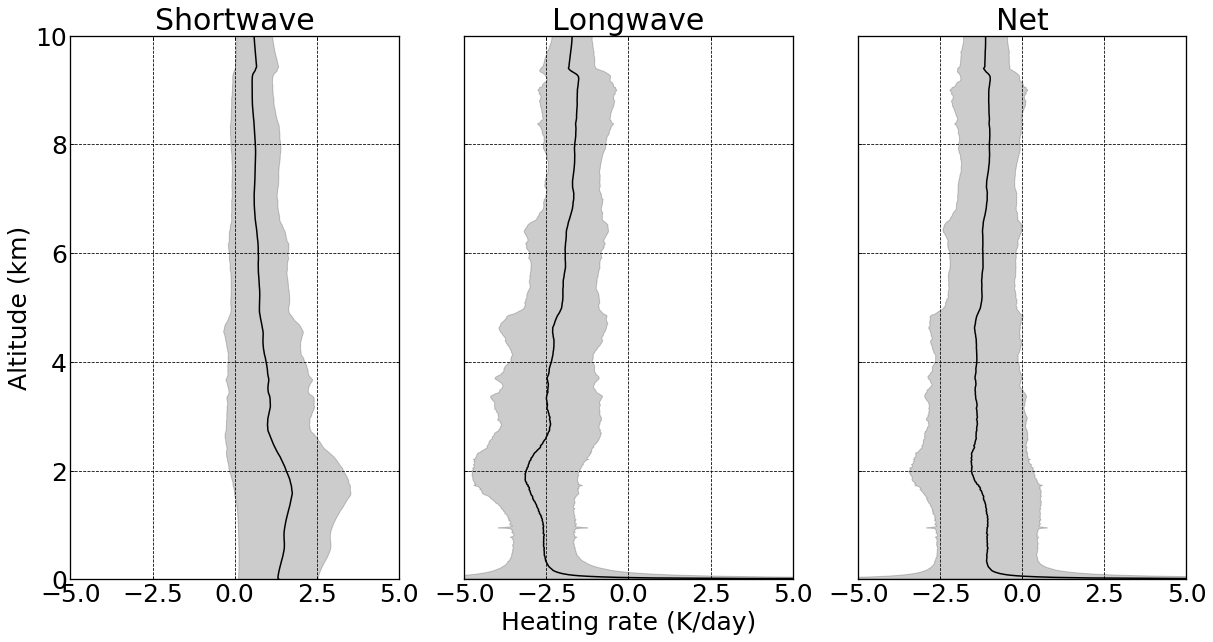

In [43]:
plot_rad_profiles(all_profiles)

# Diurnal cycle

In [44]:
def get_variables_to_plot(profiles):
    
    #get only some coordinates of the original xarray
    data = profiles["q_rad"]  
    data["q_rad_lw"] = profiles["q_rad_lw"]
    data["q_rad_sw"] = profiles["q_rad_sw"]
    data["time"] = profiles["launch_time"]
    data = data.drop_vars(["lay","col","play"])
    
    data = data.to_dataframe()
    data["time"] = data["time"].dt.tz_localize(pytz.UTC).dt.tz_convert('America/Barbados').dt.strftime("%H:%M")
    
    data["time"] = pd.to_datetime(data["time"], format="%H:%M")

    data = data.reset_index()
    data = data.set_index(["time","zlay"])
    data = data.groupby([pd.Grouper(freq='10min', level='time'), 
                                 pd.Grouper(level='zlay')]).mean()
       
    #come back to xarray and get q_rad
    data = data.to_xarray()
    q_rad = np.transpose(data.q_rad.values)
    q_rad_lw = np.transpose(data.q_rad_lw.values)
    q_rad_sw = np.transpose(data.q_rad_sw.values)
    zlay = profiles.zlay.values
    time = data.time.values
   
    
    return time, zlay, q_rad, q_rad_lw, q_rad_sw

In [45]:
def plot_diurnal_cycle(profiles):
    
    time, zlay, q_rad, q_rad_lw, q_rad_sw = get_variables_to_plot(profiles)   
 
    dates_list = [date for date in time]    
        
    fig, ax = plt.subplots(1,3,figsize=(20,10))
    
    ax[0].set_title(r'Shortwave')
    ax[0].set_ylabel('Altitude (km)')
                
    ax[1].set_title('Longwave')
    ax[1].set_xlabel('Time (Local)')


    ax[2].set_title(r'Net')

    ymin=0
    ymax=10
    
    colormap = "RdBu_r"
    val_min = -4
    val_max = 4

    zlay=zlay/1000
    
    ax[0].pcolormesh(dates_list, zlay, q_rad_sw, cmap=colormap,vmin=val_min, vmax=val_max)
    ax[1].pcolormesh(dates_list, zlay, q_rad_lw, cmap=colormap,vmin=val_min,vmax=val_max)
    im = ax[2].pcolormesh(dates_list, zlay, q_rad, cmap=colormap,vmin=val_min, vmax=val_max)
    
    myFmt = mdates.DateFormatter('%-H')
    
    for k in range(3):
        ax[k].xaxis.set_major_formatter(myFmt)
        ax[k].set_ylim([0,ymax])
    

    for k in range(3):
        ticks = ax[k].get_xticks()
        ax[k].set_xticks(np.linspace(ticks[0], mdates.date2num(mdates.num2date(ticks[-1])), 4))

    ax[1].tick_params(labelleft=False)    
    ax[2].tick_params(labelleft=False)    

    cb = fig.colorbar(im, ax=ax[2], extend="both")
    cb.ax.set_ylabel('Heating Rate (K/day)')
    
   # fig.tight_layout() 
    
  #  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    
    fig.savefig('../Figures/diurnal_cycle.jpg')    

In [39]:
count_time = np.arange(time[0], time[0] + np.timedelta64(24,'h'), np.timedelta64(10, 'm'))
count = np.zeros(len(count_time))
data = {'count_time': count_time, 'count': count}
data = pd.DataFrame(data=data)
data = data.set_index(["count_time"])

for itime in time:
    data.loc[itime, "count"] = old_count.sel(time=itime).values

                     count
count_time                
1900-01-01 00:00:00    1.0
1900-01-01 00:10:00    1.0
1900-01-01 00:20:00    1.0
1900-01-01 00:30:00    1.0
1900-01-01 00:40:00    1.0
...                    ...
1900-01-01 23:10:00    1.0
1900-01-01 23:20:00    1.0
1900-01-01 23:30:00    1.0
1900-01-01 23:40:00    1.0
1900-01-01 23:50:00    1.0

[144 rows x 1 columns]


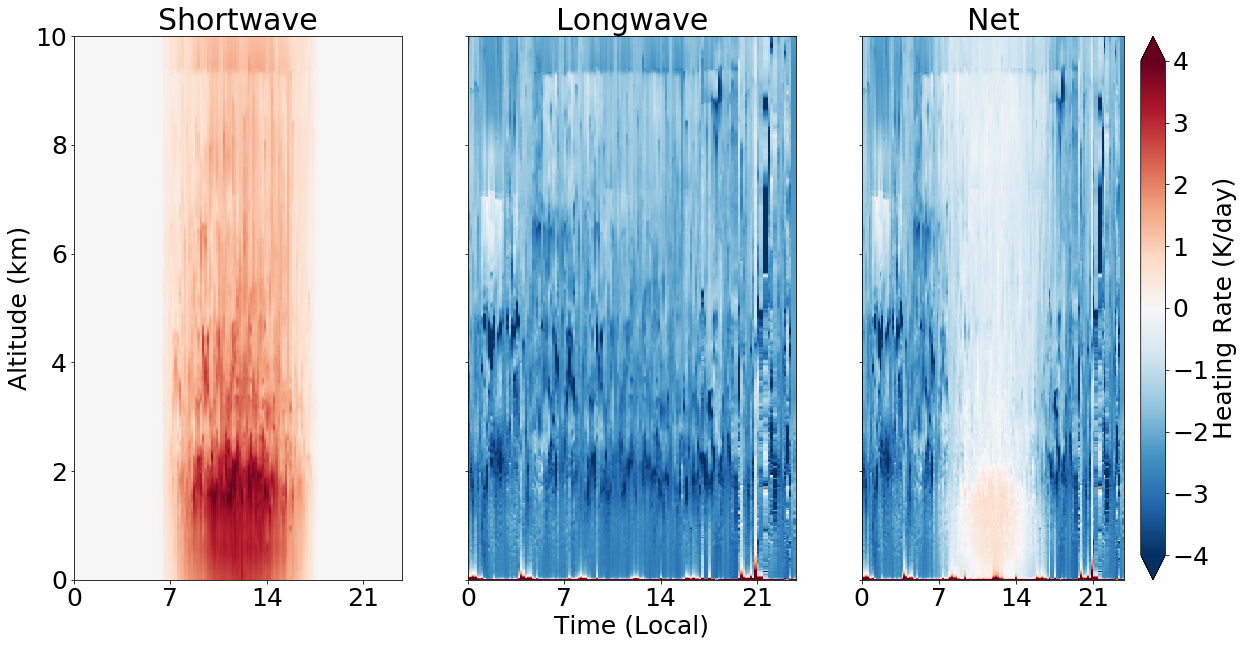

In [46]:
plot_diurnal_cycle(all_profiles)